# Setup

In [1]:
import torch
from torch import einsum
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from clasp import CLASP, Transformer, tokenize, basic_rand_sampler, basic_aa_tokenizer, CLASPDataset
from functools import partial
from collections import OrderedDict
import requests
import matplotlib.pyplot as plt

# Instantiate model

In [2]:
text_enc = Transformer(
    num_tokens = 49408,
    dim = 512,
    depth = 6,
    seq_len = 1024
)

bioseq_enc = Transformer(
    num_tokens = 23,
    dim = 512,
    depth = 6,
    seq_len = 512,
    sparse_attn = False
)

model = CLASP(
    text_encoder = text_enc,
    bioseq_encoder = bioseq_enc
)

In [4]:
path_weights = "xy/latest.pt"

In [5]:
ckpt = torch.load(path_weights, map_location="cpu")

In [6]:
# this hack seems to be needed, because the model in the ipynb has different weight names?
new_ckpt = OrderedDict()
for ((kc, vc), ko) in zip(ckpt.items(), model.state_dict().keys()):
    new_ckpt[ko] = vc

In [7]:
model.load_state_dict(new_ckpt)

<All keys matched successfully>

In [8]:
model.eval();

In [9]:
# if you wanto to run it on GPU
#device = torch.device("cuda:0")
#model.to(device)

# Tokenizer setup

In [10]:
text_sampler = partial(basic_rand_sampler, sample_len=1024)
text_tok = partial(tokenize, context_length=1024, return_mask=True)

bioseq_sampler = partial(basic_rand_sampler, sample_len=512)
bioseq_tok = partial(basic_aa_tokenizer, context_length=512, return_mask=True)

# Query example

## Bioseq

Proteins related query "blood":
1. https://www.uniprot.org/uniprot/B2RUZ4
1. https://www.uniprot.org/uniprot/A0A430QLP7

Proteins related to query "brain":
1. https://www.uniprot.org/uniprot/Q9VGE8
1. https://www.uniprot.org/uniprot/Q8C8N3

Proteins related to query "t-cell":
1. https://www.uniprot.org/uniprot/P20963
1. https://www.uniprot.org/uniprot/P60568

Proteins related to query "hormones":
1. https://www.uniprot.org/uniprot/P01215
1. https://www.uniprot.org/uniprot/O97385

Proteins related to query "virus":
1. https://www.uniprot.org/uniprot/P04298
1. https://www.uniprot.org/uniprot/Q8TDQ0

In [40]:
prot_urls = ["https://www.uniprot.org/uniprot/B2RUZ4.fasta",
             "https://www.uniprot.org/uniprot/A0A430QLP7.fasta",
             "https://www.uniprot.org/uniprot/Q9VGE8.fasta",
             "https://www.uniprot.org/uniprot/Q8C8N3.fasta",
             "https://www.uniprot.org/uniprot/P20963.fasta",
             "https://www.uniprot.org/uniprot/P60568.fasta",
             "https://www.uniprot.org/uniprot/O97385.fasta",
             "https://www.uniprot.org/uniprot/P04298.fasta",
             "https://www.uniprot.org/uniprot/Q8TDQ0.fasta"]

In [41]:
bioseq_orig =["".join(requests.get(url).text.split("\n")[1:]) for url in prot_urls]

In [42]:
bioseq_orig

['MQPQESHVHYSRWEDGSRDGVSLGAVSSTEEASRCRRISQRLCTGKLGIAMKVLGGVALFWIIFILGYLTGYYVHKCK',
 'MTLPISLMSINHCDTNIITNGNTNNNHNINNDYNVNHKIMKSLSEYHINEHKQKFHHNLQTNFKEFTCLSQIIKQTNQSAHNSEYKKEVFTSNNDNMKFFQHENEQVIQSQQYYSIPRMNEKPRDLRSHHNCLKQLINSSSPQPFDSSQITSPEDTQFSTSMPTHSSNMSDFPDSKLFHNHTIDHTDLPATTDGSFEAFKILNDPLDLNYTQTEDHMQYRSLHDTIQDGKFPYTKMNSRTISENTSNNSIQPTNIEKSYNQVKSTMSKKQTLTNFDEYPPTPSSSFSQREKISGAKLSFHHISYEVKIQKTLCSKPVIKTILDDVSGILRPGMNALMGPTGSGKSSLLDVLAGRKDPRFLSGKVLIDGRPQPKNFKCISGYVVQDDIVMGTLTVRENLSFSAALRMTMHCTTEERNQKVNDIIDELGLNAVADSKVGTELVRGVSGGERKRTSIGMELITEPPVLFLDEPTTGLDAYMAGQVPFYFIVSGYVCENHNNPPDFFMDVIHGECLRQHGNTSDVQIMDHHDTQERMHLVGQQLIQDWQTSEMAQHVLEEVSSIANRLEKYENGSKKSKDNAVDISFAASYIRQINKVCWRSILNLLRDPLASVIQTIVYLFFALSMGIVYFQMNDSLESGIQNRTGLFYFCTLQVIFVNLATIELFIKERVLFIHESSSGYYQVSVYFFSKILCDIIPTKVLPILFFMPICYWMAGLQKTFGAFMFFELLLCLTTLAAAAIALFISAKNVNTSPFRLMSVRMITPKPRKVFSGFLINLKSMAVWLSWLRYFSIFRYSMGGLLIMEMTTLRFCPMDKSNTTINRQCQNGTTYLEDQEIPYMTGWDLWSNVVGLVVIMIAFYILCYVRLRLLNKYK',
 'MRPLSGLIALALLLLLLLTAPSSAADTETESSGSPLTPG

In [43]:
[len(s) for s in bioseq_orig]

[78, 871, 289, 324, 164, 153, 102, 844, 301]

In [44]:
bioseq_ = [bioseq_tok(bioseq_sampler(s)) for s in bioseq_orig]

In [45]:
bioseq, bioseq_mask = list(zip(*bioseq_))
bioseq      = torch.cat([s.unsqueeze(0) for s in bioseq])
bioseq_mask = torch.cat([s.unsqueeze(0) for s in bioseq_mask])
bioseq, bioseq_mask

(tensor([[10, 14, 13,  ...,  0,  0,  0],
         [10,  8,  4,  ..., 13,  9,  0],
         [10, 15, 13,  ...,  0,  0,  0],
         ...,
         [10,  7,  0,  ...,  0,  0,  0],
         [ 4, 10,  9,  ...,  7, 19, 19],
         [10,  4, 16,  ...,  0,  0,  0]]),
 tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ..., False, False, False]]))

In [46]:
bioseq.shape, bioseq_mask.shape

(torch.Size([9, 512]), torch.Size([9, 512]))

In [47]:
bioseq_out = model.bioseq_encoder(bioseq, mask=bioseq_mask)
bioseq_out.shape

torch.Size([9, 512])

## Text

Change here the text query:

In [48]:
#text_orig = "protein that is present in the blood"
text_orig = "blood cells blood stream nutrition"
#text_orig = "brain neurology nerve cells"
#text_orig = "proteins that play a role in the blood transport"
#text_orig = "hormone regulation and similar functions"
#text_orig = "immune system and antigen processing"
#text_orig = "viral infection and replication"

In [49]:
text, text_mask = text_tok(text_orig)
text, text_mask

(tensor([[3590, 8890, 3590,  ...,    0,    0,    0]]),
 tensor([[ True,  True,  True,  ..., False, False, False]]))

In [50]:
text_out = model.text_encoder(text, mask=text_mask)
text_out.shape

torch.Size([1, 512])

## Similarity

In [51]:
text_out_norm = F.normalize(text_out, p=2, dim =-1)
bioseq_out_norm = F.normalize(bioseq_out, p=2, dim =-1)

In [52]:
sim = einsum('n d, n d -> n', text_out_norm, bioseq_out_norm)
sim.tolist()

[0.06864210218191147,
 0.07336428761482239,
 0.03554559871554375,
 0.013657044619321823,
 0.037616245448589325,
 0.02798568829894066,
 0.03425944596529007,
 0.061149779707193375,
 0.04801230877637863]

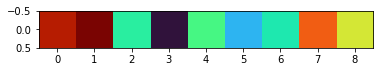

In [53]:
plt.imshow(sim.data.unsqueeze(0).numpy(), cmap="turbo");

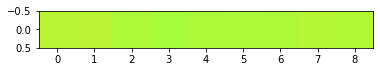

In [54]:
plt.imshow(sim.data.unsqueeze(0).numpy(), cmap="turbo", vmin=-1., vmax=1.);

# Citric acid cycle

The [citric acid cycle](https://en.wikipedia.org/wiki/Citric_acid_cycle) is a very import chain of reactions in cells and we use the sequences of some of the [involved enzymes](https://en.wikipedia.org/wiki/Citric_acid_cycle#Steps) to look for interesting relationships in the high-dimensional embedding space.

1. Citrate synthase, https://www.uniprot.org/uniprot/O75390
1. Cytoplasmic aconitate hydratase, https://www.uniprot.org/uniprot/P21399
1. Isocitrate dehydrogenase NADP cytoplasmic, https://www.uniprot.org/uniprot/O75874
1. Fumarate hydratase mitochondrial, https://www.uniprot.org/uniprot/P07954
1. Malate dehydrogenase cytoplasmic, https://www.uniprot.org/uniprot/P40925

In [26]:
cca_urls = ["https://www.uniprot.org/uniprot/O75390.fasta",
            "https://www.uniprot.org/uniprot/P21399.fasta",
            "https://www.uniprot.org/uniprot/O75874.fasta",
            "https://www.uniprot.org/uniprot/P07954.fasta",
            "https://www.uniprot.org/uniprot/P40925.fasta"]

In [27]:
# we also add the proteins from above to see if the cca proteins are clustered together
cca_seq =["".join(requests.get(url).text.split("\n")[1:]) for url in cca_urls+prot_urls]

In [28]:
cca_seq

['MALLTAAARLLGTKNASCLVLAARHASASSTNLKDILADLIPKEQARIKTFRQQHGKTVVGQITVDMMYGGMRGMKGLVYETSVLDPDEGIRFRGFSIPECQKLLPKAKGGEEPLPEGLFWLLVTGHIPTEEQVSWLSKEWAKRAALPSHVVTMLDNFPTNLHPMSQLSAAVTALNSESNFARAYAQGISRTKYWELIYEDSMDLIAKLPCVAAKIYRNLYREGSGIGAIDSNLDWSHNFTNMLGYTDHQFTELTRLYLTIHSDHEGGNVSAHTSHLVGSALSDPYLSFAAAMNGLAGPLHGLANQEVLVWLTQLQKEVGKDVSDEKLRDYIWNTLNSGRVVPGYGHAVLRKTDPRYTCQREFALKHLPNDPMFKLVAQLYKIVPNVLLEQGKAKNPWPNVDAHSGVLLQYYGMTEMNYYTVLFGVSRALGVLAQLIWSRALGFPLERPKSMSTEGLMKFVDSKSG',
 'MSNPFAHLAEPLDPVQPGKKFFNLNKLEDSRYGRLPFSIRVLLEAAIRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVPAVVDFAAMRDAVKKLGGDPEKINPVCPADLVIDHSIQVDFNRRADSLQKNQDLEFERNRERFEFLKWGSQAFHNMRIIPPGSGIIHQVNLEYLARVVFDQDGYYYPDSLVGTDSHTTMIDGLGILGWGVGGIEAEAVMLGQPISMVLPQVIGYRLMGKPHPLVTSTDIVLTITKHLRQVGVVGKFVEFFGPGVAQLSIADRATIANMCPEYGATAAFFPVDEVSITYLVQTGRDEEKLKYIKKYLQAVGMFRDFNDPSQDPDFTQVVELDLKTVVPCCSGPKRPQDKVAVSDMKKDFESCLGAKQGFKGFQVAPEHHNDHKTFIYDNTEFTLAHGSVVIAAITSCTNTSNPSVMLGAGLLAKKAVDAGLNVMPYIKTSLSPGSGVVTYYLQESGVMPYLSQLGFDVVGYGCMTCIGNSGPLPEPVVEAITQGDLV

In [29]:
[len(s) for s in cca_seq]

[466, 889, 414, 510, 334, 78, 871, 289, 324, 164, 153, 102, 844, 301]

In [30]:
bioseq_ = [bioseq_tok(bioseq_sampler(s)) for s in cca_seq]

In [31]:
bioseq, bioseq_mask = list(zip(*bioseq_))
bioseq      = torch.cat([s.unsqueeze(0) for s in bioseq])
bioseq_mask = torch.cat([s.unsqueeze(0) for s in bioseq_mask])
bioseq, bioseq_mask

(tensor([[10,  0,  9,  ...,  0,  0,  0],
         [ 5, 10,  4,  ..., 14, 19,  8],
         [10, 16,  8,  ...,  0,  0,  0],
         ...,
         [10,  7,  0,  ...,  0,  0,  0],
         [16,  9,  9,  ..., 16,  4,  6],
         [10,  4, 16,  ...,  0,  0,  0]]),
 tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ..., False, False, False]]))

In [32]:
bioseq.shape, bioseq_mask.shape

(torch.Size([14, 512]), torch.Size([14, 512]))

In [33]:
bioseq_out = model.bioseq_encoder(bioseq, mask=bioseq_mask)
bioseq_out.shape

torch.Size([14, 512])

In [34]:
u, s, v = torch.svd(bioseq_out)

In [35]:
#u, s, v
s

tensor([14.7837,  5.3171,  3.8008,  3.3596,  3.0461,  2.9466,  2.4739,  2.2731,
         1.9248,  1.7428,  1.6701,  1.5164,  1.3612,  1.0183],
       grad_fn=<SvdHelperBackward>)

In [36]:
u.shape, s.shape, v.shape

(torch.Size([14, 14]), torch.Size([14]), torch.Size([512, 14]))

In [37]:
bioseq_out.shape, v.t()[0].unsqueeze(0).shape

(torch.Size([14, 512]), torch.Size([1, 512]))

In [38]:
# project on the top-2 eigenvectors
x_coords = einsum("id, jd -> ij", bioseq_out, v.t()[0].unsqueeze(0)).data
y_coords = einsum("id, jd -> ij", bioseq_out, v.t()[1].unsqueeze(0)).data

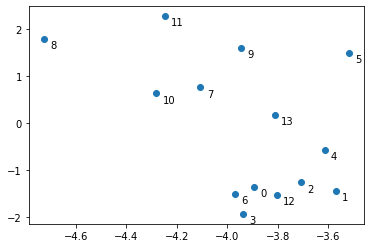

In [39]:
plt.scatter(x_coords, y_coords);
for i, txt in enumerate(x_coords):
    plt.annotate(i, (x_coords[i]+0.025, y_coords[i]-0.2))

# End